# <font color = 'indianred'>**Multilabel Classification of StackExchange Dataset using GEMMA** </font>

**Objective:**

In this notebook, we aim to use GEMMA models with QLORA for classification problems. **We will now use Casual Languagge Model - Basically we will do instruction tuning.**


**Plan**

1. Set Environment
2. Load Dataset
3. Accessing and Manipulating Splits
4. Load Pre-trained Tokenizer
5. Create Prompts
6. Model Training
  1. Download pre-trained model <br>  
  3. PEFT Setup
  4. Training Arguments <br>
  5. Instantiate Trainer <br>
  6. Setup WandB <br>
  7. Training
  8. Validation
7. Perfromance on Test Set
8. Model Inference






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [ ]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate peft bitsandbytes trl fsspec -U  -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<font color = 'indianred'> *Load Libraries* </font>

In [2]:
# standard pythgion libraries
from pathlib import Path
import re
import gc
import time
from typing import Dict, List, Union, Optional, Tuple
from tqdm import tqdm
import itertools
import json
import joblib
import ast
from datetime import datetime
from difflib import get_close_matches
import os
import sys

# Data Science librraies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

# Pytorch
import torch
import torch.nn as nn

# Huggingface Librraies
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import (
    TrainingArguments,
    Trainer,
    set_seed,
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    AutoConfig,
    pipeline,
    BitsAndBytesConfig,
)
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
    AutoPeftModelForCausalLM,
    PeftConfig
)
from huggingface_hub import login

# Logging and secrets
import wandb



In [3]:
set_seed(42)

In [4]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
base_folder = Path(basepath)
data_folder = base_folder/'datasets/Classification_HW/joblib_files'

In [5]:
base_folder

PosixPath('/content/drive/MyDrive/data')

In [6]:
def is_colab() -> bool:
    """Check if the current environment is Google Colab."""
    return 'google.colab' in sys.modules

def get_env_file_path() -> str:
    """
    Get the path to your .env file
    Modify this function to point to your .env file location
    """

    env_path = str(base_folder / '.env')

    return env_path

def get_credentials() -> Tuple[Optional[str], Optional[str]]:
    """Get credentials from either Colab or local environment."""
    wandb_api_key = None
    hf_token = None

    if is_colab():
        try:
            from google.colab import userdata
            wandb_api_key = userdata.get('WANDB_API_KEY')
            hf_token = userdata.get('HF_TOKEN')
            print("Using Google Colab environment")
        except Exception as e:
            print(f"Error accessing Colab userdata: {e}")
    else:
        # Try to load from .env file in specified location
        try:
            from dotenv import load_dotenv
            env_path = get_env_file_path()
            if os.path.exists(env_path):
                load_dotenv(env_path)
                print(f"Loaded .env file from: {env_path}")
            else:
                print(f"Warning: .env file not found at {env_path}")
        except ImportError:
            print("python-dotenv not installed. Using environment variables directly.")
        except Exception as e:
            print(f"Error loading .env file: {e}")

        wandb_api_key = os.getenv('WANDB_API_KEY')
        hf_token = os.getenv('HF_TOKEN')

    return wandb_api_key, hf_token

def setup_auth():
    """Setup authentication for both environments."""
    wandb_api_key, hf_token = get_credentials()

    # Hugging Face authentication
    if hf_token:
        try:
            from huggingface_hub import login
            login(token=hf_token)
            print("✓ Successfully logged in to Hugging Face!")
        except Exception as e:
            print(f"✗ Error logging in to Hugging Face: {e}")
    else:
        print("✗ Hugging Face token not found.")
        if is_colab():
            print("  Add HF_TOKEN to your Colab secrets")
        else:
            print(f"  Add HF_TOKEN to your .env file at {get_env_file_path()}")

    # Weights & Biases authentication
    if wandb_api_key:
        try:
            import wandb
            wandb.login(key=wandb_api_key)
            print("✓ Successfully logged in to WANDB!")
        except Exception as e:
            print(f"✗ Error logging in to WANDB: {e}")
    else:
        print("✗ WANDB API key not found.")
        if is_colab():
            print("  Add WANDB_API_KEY to your Colab secrets")
        else:
            print(f"  Add WANDB_API_KEY to your .env file at {get_env_file_path()}")

setup_auth()

Using Google Colab environment
✓ Successfully logged in to Hugging Face!


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hsingh-utd to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✓ Successfully logged in to WANDB!


# <font color = 'indianred'> **2. Load Data set**
    


In [7]:
df = joblib.load(data_folder/'df_multilabel_hw_cleaned.joblib')
df

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[1, 4]"
47423,listen phone state application nee liste phone...,java android,"[1, 4]"
47424,android ui thread thread task want access main...,java android,"[1, 4]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[9, 3]"


In [8]:
stack_dataset = Dataset.from_pandas(df)

In [9]:
selected_columns = {
    'text': stack_dataset['cleaned_text'],
    'tag': stack_dataset['Tags']
}

# Create a new dataset with the selected columns
stack_selected_columns = Dataset.from_dict(selected_columns)

In [10]:
stack_selected_columns

Dataset({
    features: ['text', 'tag'],
    num_rows: 47427
})

In [11]:
stack_selected_columns['tag'][0]

'c# asp.net'

In [12]:
# Set the format to Pandas
stack_selected_columns.set_format(type='pandas')

In [13]:
df = stack_selected_columns[:]

In [14]:
# Remove existing quotes first (if any) and then add just one set
import json
df['label'] = df['tag'].str.split().apply(lambda x: json.dumps([tag.strip() for tag in x]))


In [15]:
df

,text,tag,label
0,asp query stre dropdown webpage follow control...,c# asp.net,"[""c#"", ""asp.net""]"
1,run javascript code server java code want run ...,java javascript,"[""java"", ""javascript""]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[""c#"", ""asp.net""]"
3,run python script php server run nginx web ser...,php python,"[""php"", ""python""]"
4,advice write function m try write function res...,javascript jquery,"[""javascript"", ""jquery""]"
...,...,...,...
47422,take value edittext put decimal point all- wor...,java android,"[""java"", ""android""]"
47423,listen phone state application nee liste phone...,java android,"[""java"", ""android""]"
47424,android ui thread thread task want access main...,java android,"[""java"", ""android""]"
47425,dynamic table row creation html javascript htm...,asp.net javascript,"[""asp.net"", ""javascript""]"


In [16]:
df_final = df[['text', 'label']]

In [17]:
df_final

,text,label
0,asp query stre dropdown webpage follow control...,"[""c#"", ""asp.net""]"
1,run javascript code server java code want run ...,"[""java"", ""javascript""]"
2,linq sql throw exception row find change hi li...,"[""c#"", ""asp.net""]"
3,run python script php server run nginx web ser...,"[""php"", ""python""]"
4,advice write function m try write function res...,"[""javascript"", ""jquery""]"
...,...,...
47422,take value edittext put decimal point all- wor...,"[""java"", ""android""]"
47423,listen phone state application nee liste phone...,"[""java"", ""android""]"
47424,android ui thread thread task want access main...,"[""java"", ""android""]"
47425,dynamic table row creation html javascript htm...,"[""asp.net"", ""javascript""]"


In [18]:
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']

In [19]:
stack_selected_columns_final = Dataset.from_pandas(df_final)

In [20]:
stack_selected_columns_final[0]['label']

'["c#", "asp.net"]'

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>



<font color = 'indianred'>*Create futher subdivions of the splits*</font>

In [21]:
# Split the test set into test and validation sets
test_val_splits = stack_selected_columns_final.train_test_split(test_size=0.4, seed=42)
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42,)
val_split = test_val_splits['train']
test_split = test_val_splits['test']


<font color = 'indianred'>*small subset for initial experimenttaion*</font>

In [22]:
train_split = train_split.shuffle(seed = 42).select(range(2000))
val_split = val_split.shuffle(seed = 42).select(range(2000))
test_split = test_split.shuffle(seed = 42).select(range(2000))

In [23]:
train_val_subset= DatasetDict(
    {"train": train_split, "valid": val_split})

In [24]:
train_val_subset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [25]:
train_val_subset['train'][0]

{'text': 'edit link place use javascript edit text place need edit link click link instead make editable redirect link address change double click link editable redirect help',
 'label': '["javascript", "jquery"]'}

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>



In [26]:
def free_gpu_memory():
    """
    Frees up GPU memory after CUDA out-of-memory error in Colab.

    This function performs the following steps:
    1. Deletes all PyTorch objects to clear references.
    2. Calls garbage collection to remove unreferenced objects from memory.
    3. Uses torch.cuda.empty_cache() to release cached GPU memory.
    4. Waits for a moment to ensure memory is fully released.
    """
    try:
        # Delete all torch tensors to free up memory
        for obj in list(locals().values()):
            if torch.is_tensor(obj):
                del obj

        # Collect garbage to release any remaining unused memory
        gc.collect()

        # Empty the CUDA cache to release GPU memory
        torch.cuda.empty_cache()

        # Adding a small delay to allow memory to be fully released
        time.sleep(2)

        print("GPU memory has been freed.")
    except Exception as e:
        print(f"Error while freeing GPU memory: {e}")


In [27]:
free_gpu_memory()

GPU memory has been freed.


In [28]:
checkpoint = "google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [29]:
tokenizer.eos_token

'<eos>'

In [30]:
tokenizer.pad_token

'<pad>'

In [31]:
tokenizer.padding_side

'left'

In [32]:
tokenizer.chat_template

"{{ bos_token }}{% if messages[0]['role'] == 'system' %}{{ raise_exception('System role not supported') }}{% endif %}{% for message in messages %}{% if (message['role'] == 'user') != (loop.index0 % 2 == 0) %}{{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/...') }}{% endif %}{% if (message['role'] == 'assistant') %}{% set role = 'model' %}{% else %}{% set role = message['role'] %}{% endif %}{{ '<start_of_turn>' + role + '\n' + message['content'] | trim + '<end_of_turn>\n' }}{% endfor %}{% if add_generation_prompt %}{{'<start_of_turn>model\n'}}{% endif %}"

#<font color = 'indianred'> **5. Create Prompts**



In [33]:
class_names

['c#',
 'java',
 'php',
 'javascript',
 'android',
 'jquery',
 'c++',
 'python',
 'iphone',
 'asp.net']

In [34]:
def format_chat(example):
    instruction = f"Classify the TEXT by selecting all applicable labels from the following list: {class_names}.\n\nTEXT: {example['text']}"
    messages = [
        {"role": "user", "content": instruction},
        {"role": "assistant", "content": f"{example['label']}"}
    ]
    return {"text": tokenizer.apply_chat_template(messages, tokenize=False)}


In [35]:
train_val_subset_chat = train_val_subset.map(format_chat)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [36]:
train_val_subset_chat

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [37]:
train_val_subset_chat['train'][0]

{'text': '<bos><start_of_turn>user\nClassify the TEXT by selecting all applicable labels from the following list: [\'c#\', \'java\', \'php\', \'javascript\', \'android\', \'jquery\', \'c++\', \'python\', \'iphone\', \'asp.net\'].\n\nTEXT: edit link place use javascript edit text place need edit link click link instead make editable redirect link address change double click link editable redirect help<end_of_turn>\n<start_of_turn>model\n["javascript", "jquery"]<end_of_turn>\n',
 'label': '["javascript", "jquery"]'}

##  <font color = 'indianred'> **5.1 Filter Longer sequences**

In [38]:
def check_length(example):
   encoding = tokenizer.encode(example['text'])
   return len(encoding) <= 1000

train_filtered = train_val_subset_chat['train'].filter(check_length)
valid_filtered = train_val_subset_chat['valid'].filter(check_length)

print(f"Train: {len(train_val_subset_chat['train'])} -> {len(train_filtered)}")
print(f"Valid: {len(train_val_subset_chat['valid'])} -> {len(valid_filtered)}")

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train: 2000 -> 1953
Valid: 2000 -> 1959


#  <font color = 'indianred'> **6. Model Training**

##  <font color = 'indianred'> **6.1 Download pre-trained model**

In [39]:
def get_appropriate_dtype():
    if torch.cuda.is_available() and torch.cuda.get_device_capability(0) >= (8, 0):
        return torch.bfloat16
    return torch.float16

In [40]:
torch_data_type = get_appropriate_dtype()
torch_data_type

torch.bfloat16

In [41]:
bnb_config = BitsAndBytesConfig(
  load_in_4bit=True,
  bnb_4bit_quant_type="nf4",
  bnb_4bit_use_double_quant=True,
  bnb_4bit_compute_dtype=torch_data_type,
  bnb_4bit_quant_storage=torch_data_type,
)

In [42]:
model = AutoModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

##  <font color = 'indianred'> **6.2 PEFT Setup**

In [43]:
model

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_

In [44]:
def find_linear_layers(model):
    """
    Extracts the unique names of Linear layers from a model.

    Args:
    model (nn.Module): The model from which to extract Linear layer names.

    Returns:
    list: A list of unique names of Linear layers.
    """
    # Convert the model's modules to string
    model_modules = str(model.modules)
    # Pattern to extract names of Linear layers
    pattern = r'\((\w+)\): Linear'
    # Find all occurrences of the pattern
    linear_layer_names = re.findall(pattern, model_modules)
    print(linear_layer_names)
    # Get unique names using a set, then convert back to list
    target_modules = list(set(linear_layer_names))
    return target_modules

In [45]:
find_linear_layers(model)

['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj', 'lm_head']


['v_proj',
 'lm_head',
 'q_proj',
 'down_proj',
 'up_proj',
 'o_proj',
 'gate_proj',
 'k_proj']

In [46]:
TaskType.CAUSAL_LM

<TaskType.CAUSAL_LM: 'CAUSAL_LM'>

In [47]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=128,
    lora_alpha=256,
    lora_dropout=0.01,
    target_modules = ['v_proj',  'q_proj',  'up_proj', 'o_proj', 'down_proj', 'gate_proj','k_proj'])

lora_model = get_peft_model(model, peft_config )
# qlora_model.resize_token_embeddings(len(tokenizer))
lora_model.print_trainable_parameters()

trainable params: 166,133,760 || all params: 2,780,475,648 || trainable%: 5.9750


## <font color = 'indianred'> **6.3 Training Arguments**</font>







In [48]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder/'models/gemma_qlora_lmh_inst'

# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)
run_name= 'stack_exp_lmh_gemma_inst'

use_fp16 = torch_data_type == torch.float16
use_bf16 = torch_data_type == torch.bfloat16

# Configure training parameters
training_args = SFTConfig(
    seed = 42,
    dataset_text_field="text",
    max_seq_length = 1024,
    packing = False,

    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    per_device_train_batch_size=4, # Number of samples per training batch for each device
    per_device_eval_batch_size=4,  # Number of samples per evaluation batch for each device
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant":False},
    # torch_empty_cache_steps=5,
    weight_decay=0.0,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_loss",
    greater_is_better=False,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= run_name,  # Experiment name for Weights & Biases

    # Precision settings determined based on GPU capability
    fp16=use_fp16 ,  # Set True if torch_data_type is torch.float16
    bf16=use_bf16,  # Set True if torch_data_type is torch.bfloat16
    tf32=False,  # Disable tf32 unless you want to use Ampere specific optimization
)


In [49]:
# If gradient checkpointing is enabled, configure relevant settings
if training_args.gradient_checkpointing:
    model.config.use_cache = False  # Disable caching for compatibility



##  <font color = 'indianred'> **6.4 Initialize Trainer**</font>



In [50]:
data_collator_comp = DataCollatorForCompletionOnlyLM(tokenizer=tokenizer, mlm=False,
                                                      response_template="<start_of_turn>model\n")

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_filtered,
    eval_dataset=valid_filtered,
    peft_config=peft_config,
    data_collator=data_collator_comp
)

/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Converting train dataset to ChatML:   0%|          | 0/1953 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/1953 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1953 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1953 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/1959 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/1959 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/1959 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1959 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## <font color = 'indianred'> **6.5 Setup WandB**</font>

In [51]:
%env WANDB_PROJECT = multilabel_stack

env: WANDB_PROJECT=multilabel_stack


##  <font color = 'indianred'> **6.7 Training**

In [52]:
try:
    # Your code that may cause a CUDA out-of-memory error
    # Example: trainer.train() or other GPU intensive operations
    # lora_model.config.use_cache = False
    trainer.train()
except RuntimeError as e:
    if 'CUDA out of memory' in str(e):
        print("CUDA out of memory error detected. Freeing GPU memory.")
        free_gpu_memory()
        # Optionally, you can retry the operation here after freeing up memory
        # Example retry:
        # trainer.train()
    else:
        raise e


It is strongly recommended to train Gemma2 models with the `eager` attention implementation instead of `sdpa`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.


Step,Training Loss,Validation Loss
20,0.566500,0.108760
40,0.119600,0.093757
60,0.087300,0.081655
80,0.057900,0.081743
100,0.067000,0.077992
120,0.062300,0.075794


In [53]:
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]

In [54]:
best_model_checkpoint_step

'120'

In [55]:
# best_model_checkpoint_step =120

##  <font color = 'indianred'> **6.8 Validation**

<font color = 'indianred'> *Evaluate model on Validation Set* </font>


In [56]:
# tokenizer.apply_chat_template??

In [64]:
free_gpu_memory()

GPU memory has been freed.


In [65]:
def format_chat_inference(example):
    instruction = f"Classify the TEXT by selecting all applicable labels from the following list: {class_names}.\n\nTEXT: {example['text']}"
    messages = [
        {"role": "user", "content": instruction},
        # {"role": "assistant", "content": ""}
    ]
    # text = tokenizer.apply_chat_template(messages, tokenize=False)
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    # Remove the final <end_of_turn>
    # if text.endswith("<end_of_turn>\n"):
    #     text = text[:-len("<end_of_turn>\n")]
    return {"text": text}

In [66]:
valid_subset= train_val_subset['valid'].map(format_chat_inference)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [67]:
valid_filtered = valid_subset.filter(check_length)

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [68]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/data/models/gemma_qlora_lmh_inst/checkpoint-120'

In [69]:
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [70]:
model.device

device(type='cuda', index=0)

In [71]:
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

In [72]:
def run_inference_instruction(
    seed: int,
    dataset: Union[Dict, List],
    model,
    tokenizer,
    per_device_batch_size: int,
    input_field: str,
    output_field: str,
    save_dir: Optional[Path] = None,
    save_file_name: Optional[str] = None,
    max_new_tokens: int = 10,
    num_beams: int = 1,
    do_sample: bool = False,
    top_k: int = 50,
    top_p: float = 1.0,
    temperature: float = 1.0,
    no_repeat_ngram_size: int = 2,
    num_return_sequences: int = 1
) -> List[Dict]:

    """
    Run inference on a dataset using a pre-trained model and return the complete generations.

    Args:
        seed (int): Random seed for reproducibility
        dataset (Union[Dict, List]): Input dataset containing text to generate from
        model: Pre-trained model to use for inference
        tokenizer: Tokenizer associated with the model
        per_device_batch_size (int): Number of samples to process in each batch
        input_field (str): Key name for accessing input text in the dataset
        output_field (str): Key name for accessing ground truth labels in the dataset
        save_dir (Optional[Path]): Directory path to save generation results. If None, results won't be saved
        save_file_name (Optional[str]): Name of the file to save results. If None, uses timestamp
        max_new_tokens (int, optional): Maximum number of tokens to generate. Defaults to 10
        num_beams (int, optional): Number of beams for beam search. Defaults to 1
        do_sample (bool, optional): Whether to use sampling. Defaults to False
        top_k (int, optional): Number of highest probability tokens to keep for top-k sampling. Defaults to 50
        top_p (float, optional): Cumulative probability cutoff for top-p sampling. Defaults to 1.0
        temperature (float, optional): Sampling temperature; higher means more random. Defaults to 1.0
        no_repeat_ngram_size (int, optional): Size of n-grams to prevent repetition. Defaults to 2
        num_return_sequences (int, optional): Number of sequences to generate per input. Defaults to 1

    Returns:
        List[Dict]: List of dictionaries containing:
            - "input": Original input text
            - "generated_output": Model-generated text
            - "ground_truth": Ground truth label if available, "N/A" if not

    """



    set_seed(seed)
    model.eval()
    device = model.device
    batch_size = per_device_batch_size
    inference_results = []


    progress_bar = tqdm(range(0, len(dataset), batch_size), desc="Generating predictions")

    for i in progress_bar:
       batch = dataset[i:i + batch_size]

       try:
           texts = batch[input_field]
           labels = batch[output_field] if output_field in batch else ["N/A"] * len(texts)


           inputs = tokenizer(texts, return_tensors="pt", padding=True)
           inputs = {k: v.to(device) for k, v in inputs.items()}

           with torch.no_grad():
               outputs = model.generate(
                   **inputs,
                   max_new_tokens=max_new_tokens,
                   num_beams=num_beams,
                   do_sample=do_sample,
                   top_k=top_k,
                   top_p=top_p,
                   temperature=temperature,
                   pad_token_id=tokenizer.pad_token_id,
               )

           decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=False)

           for text, label, decoded_output in zip(texts, labels, decoded_outputs):
                   inference_results.append({
                    "input": text,
                    "generated_output": decoded_output,
                    "ground_truth": label
                })


       except Exception as e:
           print(f"Error processing batch: {str(e)}")
           continue
    # Save generations if path provided
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        # If no filename provided, create a timestamped one
        if save_file_name is None:
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            save_name = f"generations_{timestamp}.json"
        elif not save_file_name.endswith('.json'):
            save_name = f"{save_file_name}.json"

        save_file = save_dir / save_name

        with open(save_file, 'w') as f:
            json.dump(inference_results, f, indent=2)
        print(f"Saved inference_results to: {save_file}")

    return inference_results

In [73]:
free_gpu_memory()

GPU memory has been freed.


In [74]:
valid_filtered

Dataset({
    features: ['text', 'label'],
    num_rows: 1960
})

In [75]:
valid_filtered[0]['label']

'["javascript", "jquery"]'

In [76]:
valid_filtered[0]['text']

'<bos><start_of_turn>user\nClassify the TEXT by selecting all applicable labels from the following list: [\'c#\', \'java\', \'php\', \'javascript\', \'android\', \'jquery\', \'c++\', \'python\', \'iphone\', \'asp.net\'].\n\nTEXT: seperate jquery script selector external file work jquery selector event associate want external file copy directly save thing external javascript selector work explain note able use function html file externalize work script follows:-   $ pervious\').click(function          var presentslide = $ .visible\').attr(\'id          var temparr = presentslide.split("-          var persentslideno = temparr[1          var perviousslideno = number(persentslideno 1 perviousslideno > -1                    var perviousslide = slide- + perviousslideno               $ + presentslide).fadeout(\'slow\',function              $ this).removeclass(\'visible\').addclass(\'hidden                           $ + perviousslide).fadein(\'slow\',function              $ this).removeclass(\

In [77]:
valid_inference_results = run_inference_instruction(seed = 42,
              dataset=valid_filtered,
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=50,
              input_field='text',
              output_field='label',
              save_dir=model_folder,
              save_file_name = 'valid_complete_generations')

Generating predictions: 100%|██████████| 40/40 [02:28<00:00,  3.72s/it]

Saved inference_results to: /content/drive/MyDrive/data/models/gemma_qlora_lmh_inst/valid_complete_generations.json


In [78]:
file_name = model_folder/'valid_complete_generations.json'
with open(file_name, 'r') as f:
    valid_inference_results = json.load(f)

In [79]:
valid_inference_results[0]

{'input': '<bos><start_of_turn>user\nClassify the TEXT by selecting all applicable labels from the following list: [\'c#\', \'java\', \'php\', \'javascript\', \'android\', \'jquery\', \'c++\', \'python\', \'iphone\', \'asp.net\'].\n\nTEXT: seperate jquery script selector external file work jquery selector event associate want external file copy directly save thing external javascript selector work explain note able use function html file externalize work script follows:-   $ pervious\').click(function          var presentslide = $ .visible\').attr(\'id          var temparr = presentslide.split("-          var persentslideno = temparr[1          var perviousslideno = number(persentslideno 1 perviousslideno > -1                    var perviousslide = slide- + perviousslideno               $ + presentslide).fadeout(\'slow\',function              $ this).removeclass(\'visible\').addclass(\'hidden                           $ + perviousslide).fadein(\'slow\',function              $ this).rem

In [82]:
from pprint import pprint
pprint(valid_inference_results[1]['generated_output'])

('<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [83]:
pprint(valid_inference_results[2]['generated_output'])

('<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pa

In [84]:
output_delimiter = "<start_of_turn>model\n"
def extract_content(generated_output: str, output_delimiter: str) -> str:
    """
    Extract content after delimiter from a generated output string.

    Args:
        generated_output: String containing the complete model generation
        output_delimiter: Delimiter to extract content after

    Returns:
        Extracted content as string, or None if delimiter not found
    """
    pattern = f'{re.escape(output_delimiter.strip())}\\s*(.*?)<end_of_turn>'
    match = re.search(pattern, generated_output, re.DOTALL)
    return match.group(1).strip() if match else None

In [85]:
valid_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in valid_inference_results
]

In [86]:
valid_extracted_outputs[0]

'["javascript", "jquery"]'

In [87]:
for i in range(20):
  print(valid_extracted_outputs[i])

["javascript", "jquery"]
["javascript", "jquery"]
["java", "android"]
["java", "android"]
["c#", "javascript"]
["javascript", "jquery"]
["javascript", "jquery"]
["c#", "asp.net"]
["java", "android"]
["javascript", "jquery"]
["javascript", "iphone"]
["java", "android"]
["c#", "asp.net"]
["javascript", "jquery"]
["javascript", "jquery"]
["javascript", "jquery"]
["java", "android"]
["javascript", "asp.net"]
["javascript", "jquery"]
["java", "iphone"]


In [88]:
for i in range(20):
  print(valid_inference_results[i]['ground_truth'])

["javascript", "jquery"]
["javascript", "jquery"]
["java", "android"]
["c#", "asp.net"]
["c#", "javascript", "asp.net"]
["javascript", "jquery"]
["javascript", "jquery"]
["c#", "asp.net"]
["java", "android"]
["javascript", "jquery"]
["javascript", "iphone"]
["java", "android"]
["c#", "asp.net"]
["javascript", "jquery"]
["php", "jquery"]
["javascript", "jquery"]
["java", "android"]
["c#", "javascript", "asp.net"]
["javascript", "jquery"]
["android", "iphone"]


In [89]:
def clean_and_split_labels(extracted_output: str, class_names: List[str], cutoff: float = 0.6) -> List[str]:
    """
    Clean and normalize extracted content for multi-label classification.

    Args:
        extracted_output: String containing extracted labels
        class_names: List of valid class names
        cutoff: Threshold for fuzzy matching

    Returns:
        List of cleaned and normalized labels
    """
    from difflib import get_close_matches

    # Convert to string if not already
    if isinstance(extracted_output, (list, tuple)):
        label_set = ' '.join(str(x) for x in extracted_output)
    else:
        label_set = str(extracted_output)

    # Basic cleaning
    label_set = label_set.lstrip('=')
    # Remove various bracket and quote combinations
    label_set = label_set.replace('=["', '').replace('["', '').replace('"]', '')
    label_set = label_set.replace("['", '').replace("']", '')
    label_set = label_set.replace('("', '').replace('")', '')
    label_set = label_set.replace('(["', '').replace('"])', '')
    label_set = label_set.replace('([', '').replace('])', '')
    label_set = label_set.replace('[', '').replace(']', '')
    label_set = label_set.replace('(', '').replace(')', '')
    label_set = label_set.replace('"', '').replace("'", '')

    # Handle multiple types of separators
    label_set = ' '.join(label_set.split())  # normalize spaces
    raw_labels = label_set.split(',') if ',' in label_set else label_set.split()

    # Clean and normalize labels
    raw_labels = [label.strip().lower() for label in raw_labels if label.strip()]

    # Match to valid classes using fuzzy matching
    cleaned_labels = []
    for label in raw_labels:
        if label in class_names:
            cleaned_labels.append(label)
        else:
            matches = get_close_matches(label, class_names, n=1, cutoff=cutoff)
            if matches:
                cleaned_labels.append(matches[0])

    # Remove duplicates while preserving order
    seen = set()
    cleaned_labels = [x for x in cleaned_labels if not (x in seen or seen.add(x))]

    return cleaned_labels

In [90]:
# Clean and convert predictions and ground truth
valid_predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in valid_extracted_outputs
]

valid_labels = [
    clean_and_split_labels(result['ground_truth'], class_names)
    for result in valid_inference_results
]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)  # Fit with all possible classes

# Transform the data
valid_labels_binary = mlb.transform(valid_labels)
valid_predictions_binary = mlb.transform(valid_predictions)

# Print samples and shapes
print("Sample of true labels:", valid_labels[:5])
print("Sample of predictions:", valid_predictions[:5])
print("\nBinary format:")
print("Labels shape:", valid_labels_binary.shape)
print("Predictions shape:", valid_predictions_binary.shape)

Sample of true labels: [['javascript', 'jquery'], ['javascript', 'jquery'], ['java', 'android'], ['c#', 'asp.net'], ['c#', 'javascript', 'asp.net']]
Sample of predictions: [['javascript', 'jquery'], ['javascript', 'jquery'], ['java', 'android'], ['java', 'android'], ['c#', 'javascript']]

Binary format:
Labels shape: (1960, 10)
Predictions shape: (1960, 10)


In [91]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')
accuracy_flatten = evaluate.load('accuracy')
def compute_metrics( labels, preds):
  accuracy_label = accuracy_flatten.compute(predictions=preds.flatten(), references=labels.flatten())
  accuracy_all = accuracy.compute(predictions=preds, references=labels)
  f1_micro = f1.compute(predictions=preds, references=labels, average='micro')
  f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
  return {'f1_micro':f1_micro['f1'],
          'f1_macro':f1_macro['f1'],
          'accuracy_label':accuracy_label['accuracy'],
            'accuracy_all':accuracy_all['accuracy']}

In [92]:
valid_metrics = compute_metrics(valid_labels_binary , valid_predictions_binary)

In [94]:
valid_metrics

{'f1_micro': 0.9032581453634085, 'f1_macro': 0.8147304023086732, 'accuracy_label': 0.9606122448979592, 'accuracy_all': 0.8107142857142857}

In [95]:
wandb.log({"valid_f1_macro": valid_metrics["f1_macro"]})

<font color = 'indianred'> *Confusion Matrix*</font>

In [96]:
mcm = multilabel_confusion_matrix(valid_labels_binary , valid_predictions_binary)
print(mcm)

[[[1468   56]
  [  68  368]]

 [[1640    8]
  [  24  288]]

 [[1727   17]
  [  48  168]]

 [[ 712   71]
  [ 103 1074]]

 [[1671    1]
  [  22  266]]

 [[ 855   48]
  [  69  988]]

 [[1924    2]
  [  11   23]]

 [[1936    0]
  [   6   18]]

 [[1901   45]
  [   7    7]]

 [[1390   45]
  [ 121  404]]]


In [97]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats


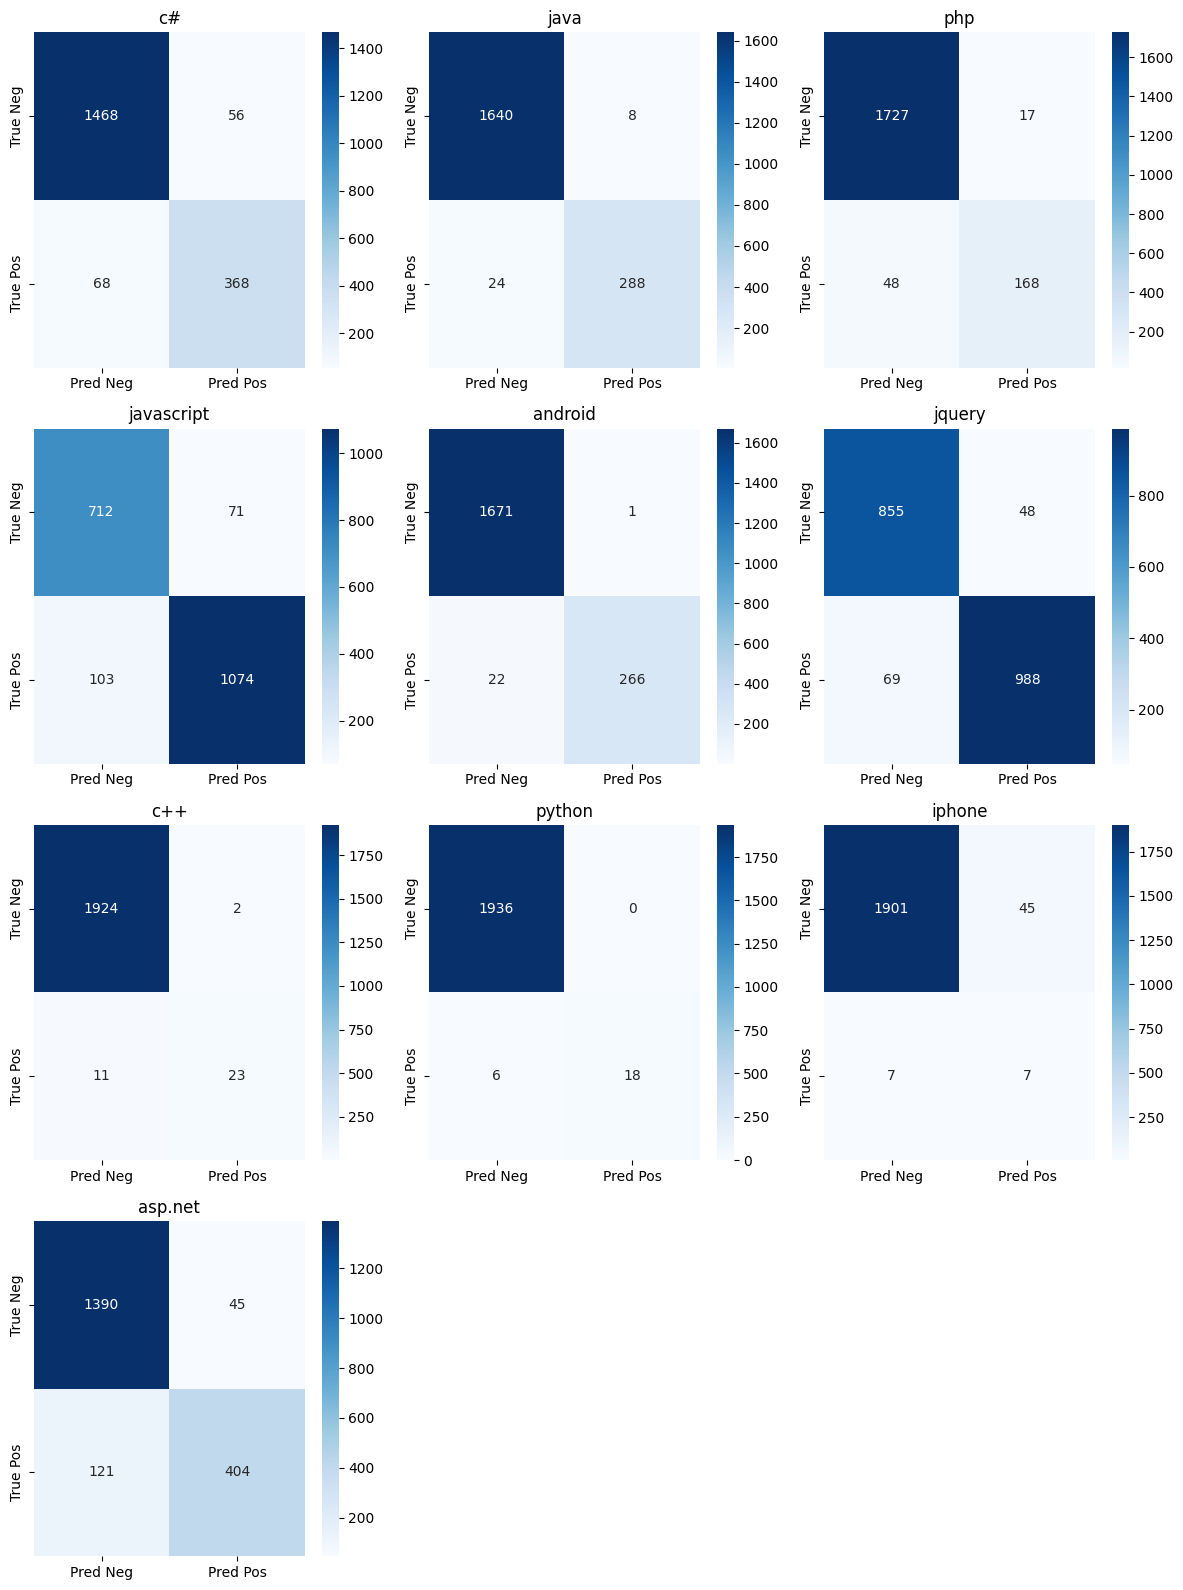

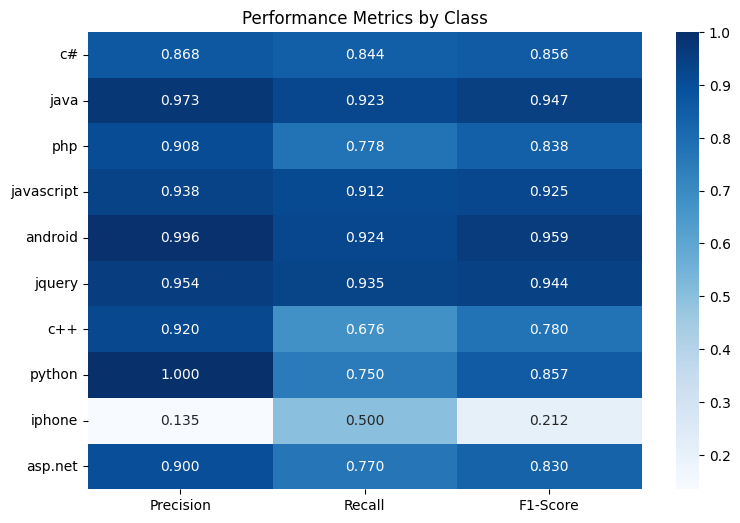

<Figure size 1200x533.333 with 0 Axes>

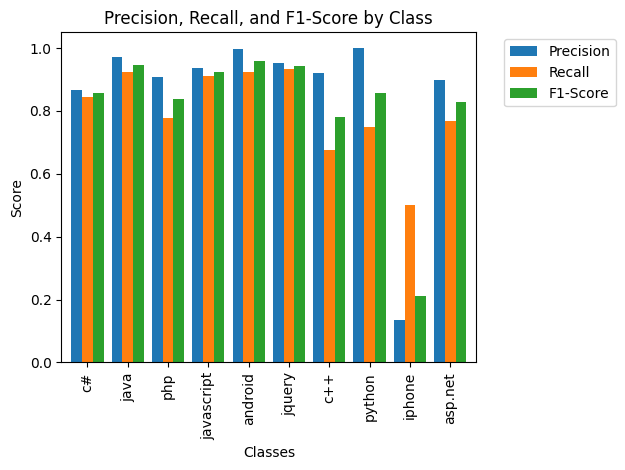

{'macro_avg': {'precision': np.float64(0.8591312178540573), 'recall': np.float64(0.8011707194982562), 'f1': np.float64(0.8147304023086732)}, 'per_class': {'Precision': {'c#': 0.8679245283018868, 'java': 0.972972972972973, 'php': 0.9081081081081082, 'javascript': 0.9379912663755459, 'android': 0.9962546816479401, 'jquery': 0.9536679536679536, 'c++': 0.92, 'python': 1.0, 'iphone': 0.1346153846153846, 'asp.net': 0.8997772828507795}, 'Recall': {'c#': 0.8440366972477065, 'java': 0.9230769230769231, 'php': 0.7777777777777778, 'javascript': 0.9124893797790994, 'android': 0.9236111111111112, 'jquery': 0.934720908230842, 'c++': 0.6764705882352942, 'python': 0.75, 'iphone': 0.5, 'asp.net': 0.7695238095238095}, 'F1-Score': {'c#': 0.8558139534883721, 'java': 0.9473684210526315, 'php': 0.8379052369077307, 'javascript': 0.9250645994832042, 'android': 0.9585585585585585, 'jquery': 0.9440993788819876, 'c++': 0.7796610169491526, 'python': 0.8571428571428571, 'iphone': 0.21212121212121213, 'asp.net': 0.

In [98]:
multilabel_evaluation(y_true=valid_labels_binary, y_pred=valid_predictions_binary, class_names=class_names, figsize=(12, 8))

#  <font color = 'indianred'> **7. Performance on Test Set** </font>
For test set evaluation, we will perfrom following steps:



In [99]:
test_split

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

In [100]:
test_split = test_split.map(format_chat_inference)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [101]:
test_filtered = test_split.filter(check_length)

print(f"Train: {len(train_split)} -> {len(test_filtered)}")


Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Train: 2000 -> 1957


In [102]:
test_filtered

Dataset({
    features: ['text', 'label'],
    num_rows: 1957
})

In [103]:
free_gpu_memory()

GPU memory has been freed.


In [104]:
test_inference_results = run_inference_instruction(seed = 42,
              dataset=test_filtered,
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=40,
              input_field='text',
              output_field='label',
              save_dir=model_folder,
              save_file_name = 'test_complete_generations')

Generating predictions: 100%|██████████| 49/49 [02:36<00:00,  3.20s/it]

Saved inference_results to: /content/drive/MyDrive/data/models/gemma_qlora_lmh_inst/test_complete_generations.json


In [105]:
file_name = model_folder/'test_complete_generations.json'
with open(file_name, 'r') as f:
    test_inference_results = json.load(f)

In [106]:
test_extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in test_inference_results
]

# Clean and convert predictions and ground truth
test_predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in test_extracted_outputs
]

test_labels = [
    clean_and_split_labels(result['ground_truth'], class_names)
    for result in test_inference_results
]

# Initialize MultiLabelBinarizer with known classes
mlb = MultiLabelBinarizer(classes=class_names)
mlb.fit(class_names)  # Fit with all possible classes

# Transform the data
test_labels_binary = mlb.transform(test_labels)
test_predictions_binary = mlb.transform(test_predictions)

# Print samples and shapes
print("Sample of true labels:", test_labels[:5])
print("Sample of predictions:", test_predictions[:5])
print("\nBinary format:")
print("Labels shape:", test_labels_binary.shape)
print("Predictions shape:", test_predictions_binary.shape)

Sample of true labels: [['java', 'android'], ['c#', 'asp.net'], ['php', 'javascript', 'jquery'], ['c#', 'asp.net'], ['c#', 'javascript', 'jquery', 'asp.net']]
Sample of predictions: [['java', 'android'], ['java', 'android'], ['php', 'javascript'], ['c#', 'asp.net'], ['javascript', 'asp.net']]

Binary format:
Labels shape: (1957, 10)
Predictions shape: (1957, 10)


In [107]:
test_metrics = compute_metrics(test_labels_binary , test_predictions_binary)

In [108]:
test_metrics

{'f1_micro': 0.8967336683417085, 'f1_macro': 0.7948524131171723, 'accuracy_label': 0.9579969340827797, 'accuracy_all': 0.8048032703117016}

In [109]:
wandb.log({"test_f1_macro": test_metrics["f1_macro"]})

<font color = 'indianred'> *Confusion Matrix*</font>


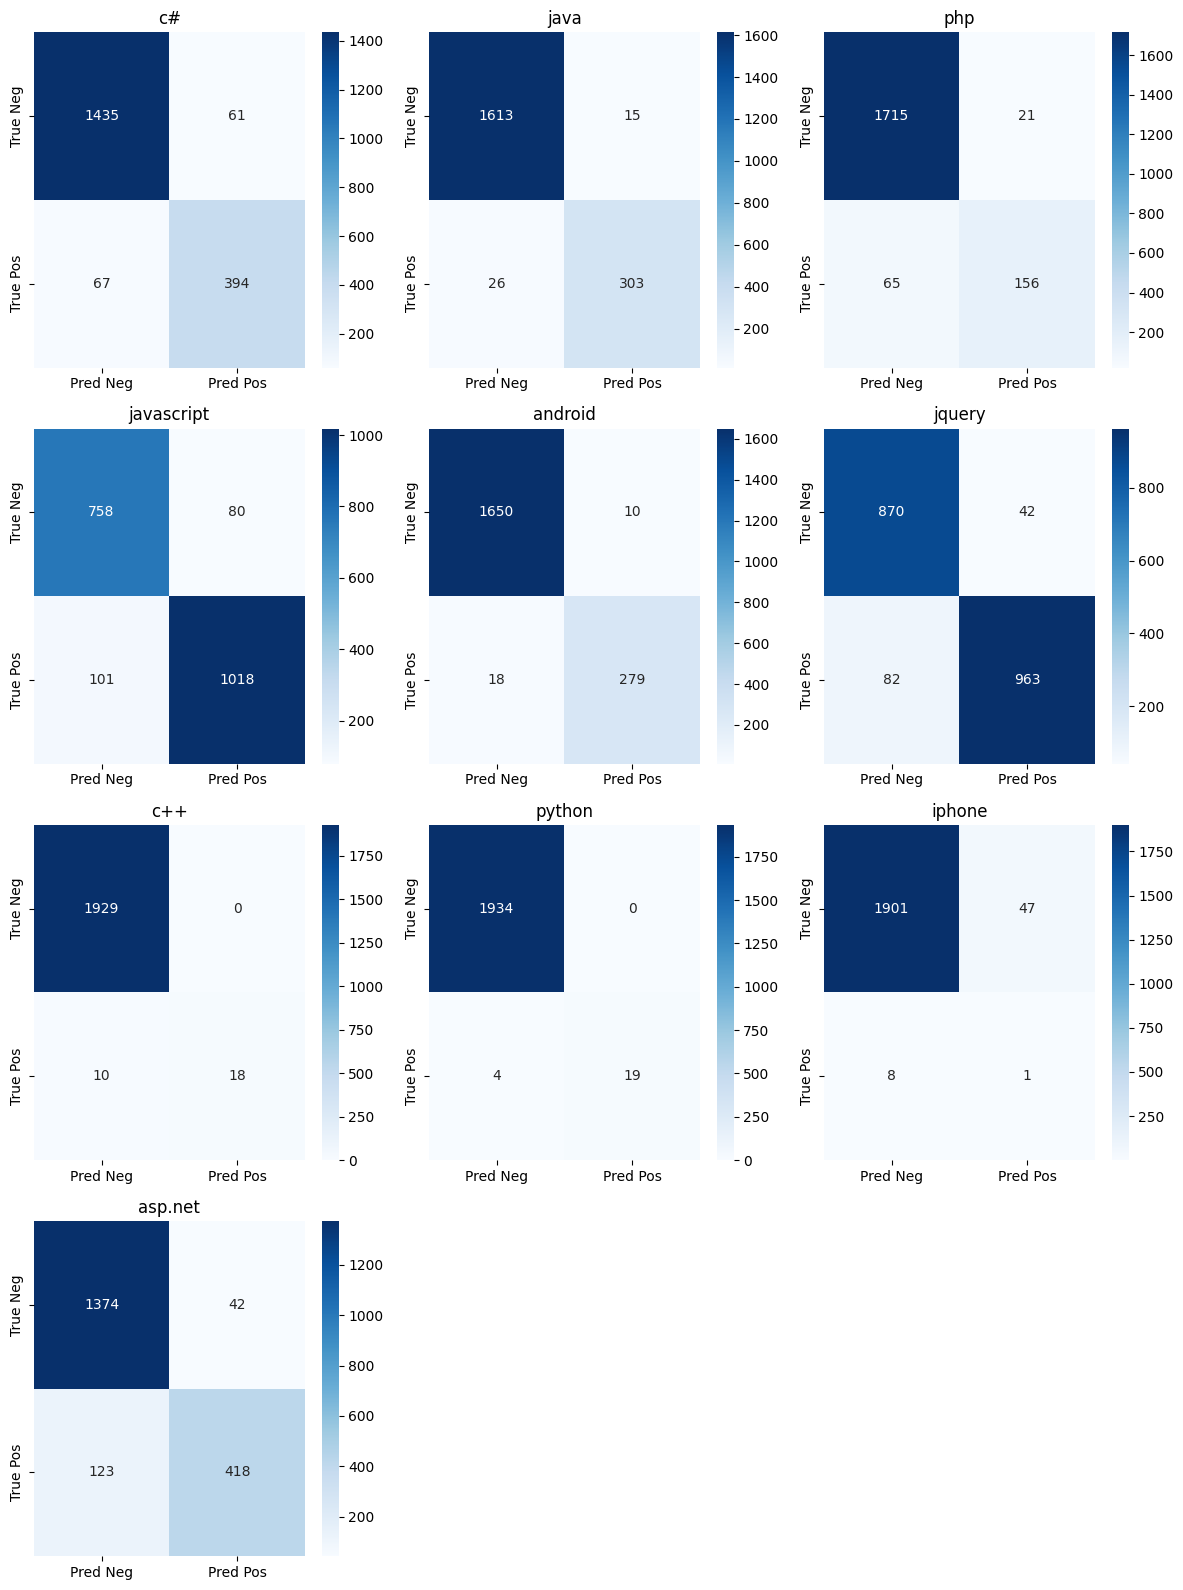

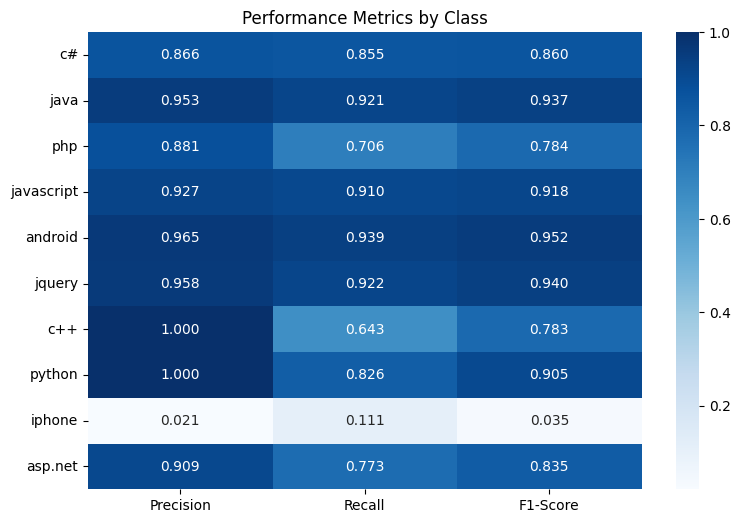

<Figure size 1200x533.333 with 0 Axes>

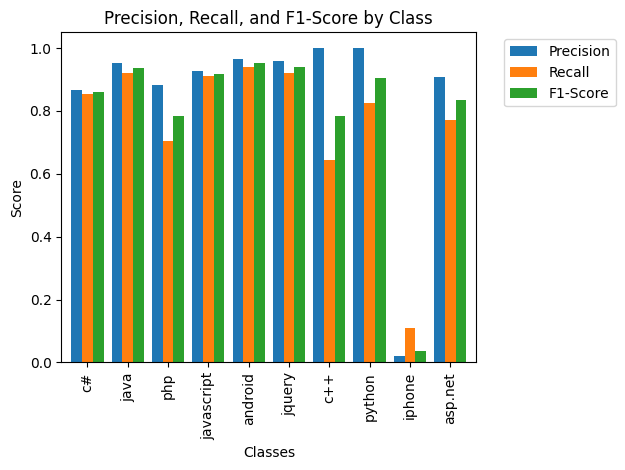

{'macro_avg': {'precision': np.float64(0.8480396306432368), 'recall': np.float64(0.7604883115354445), 'f1': np.float64(0.7948524131171723)}, 'per_class': {'Precision': {'c#': 0.865934065934066, 'java': 0.9528301886792453, 'php': 0.8813559322033898, 'javascript': 0.9271402550091075, 'android': 0.9653979238754326, 'jquery': 0.9582089552238806, 'c++': 1.0, 'python': 1.0, 'iphone': 0.020833333333333332, 'asp.net': 0.908695652173913}, 'Recall': {'c#': 0.8546637744034707, 'java': 0.9209726443768997, 'php': 0.7058823529411765, 'javascript': 0.9097408400357462, 'android': 0.9393939393939394, 'jquery': 0.9215311004784689, 'c++': 0.6428571428571429, 'python': 0.8260869565217391, 'iphone': 0.1111111111111111, 'asp.net': 0.7726432532347505}, 'F1-Score': {'c#': 0.8602620087336245, 'java': 0.9366306027820711, 'php': 0.7839195979899497, 'javascript': 0.9183581416328371, 'android': 0.9522184300341296, 'jquery': 0.9395121951219512, 'c++': 0.782608695652174, 'python': 0.9047619047619048, 'iphone': 0.035

In [110]:
multilabel_evaluation(y_true=test_labels_binary, y_pred=test_predictions_binary, class_names=class_names, figsize=(12, 8))

In [111]:
wandb.finish()

eval/loss,█▅▂▂▁▁
eval/mean_token_accuracy,▁▄▆▇▇█
eval/num_tokens,▁▂▄▅▇█
eval/runtime,▇▁▃▄██
eval/samples_per_second,▂█▆▅▁▁
eval/steps_per_second,▂█▆▄▁▁
test_f1_macro,▁
train/epoch,▁▁▂▂▄▄▅▅▆▆███
train/global_step,▁▁▂▂▄▄▅▅▆▆█████
train/grad_norm,▄▃▄▁█▄
train/learning_rate,█▇▅▄▂▁


# <Font color = 'indianred'> **8. Model Inference**



In [112]:
model_folder = base_folder/'models/gemma_qlora_lmh_inst'
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
model = AutoPeftModelForCausalLM.from_pretrained(checkpoint,
                                             quantization_config=bnb_config,
                                             torch_dtype=torch_data_type,
                                             trust_remote_code=True,
                                             device_map='auto')
peft_config = PeftConfig.from_pretrained(checkpoint)
base_model_name = peft_config.base_model_name_or_path
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [113]:
inference_results = run_inference_instruction(seed = 42,
              dataset=test_filtered.select(range(10)),
              model=model,
              tokenizer=tokenizer,
              per_device_batch_size=40,
              input_field='text',
              output_field='label',
              save_dir=model_folder,
              save_file_name = 'test_complete_generations')

Generating predictions: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]

Saved inference_results to: /content/drive/MyDrive/data/models/gemma_qlora_lmh_inst/test_complete_generations.json


In [114]:
extracted_outputs = [
    extract_content(result['generated_output'], output_delimiter)
    for result in inference_results
]

# Clean and convert predictions and ground truth
predictions = [
    clean_and_split_labels(extracted_output, class_names)
    for extracted_output in extracted_outputs

]

In [115]:
predictions

[['java', 'android'], ['java', 'android'], ['php', 'javascript'], ['c#', 'asp.net'], ['javascript', 'asp.net'], ['javascript', 'jquery'], ['javascript', 'jquery'], ['java', 'android'], ['php', 'javascript'], ['c#', 'asp.net']]